In [1]:
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema


from fink_utils.sso import spins as finkus
import ssptools

# Get ZTF fit

In [2]:
# Local Configuration
bft_file = '/data/ssodnet/ssoBFT-latest.parquet'
data_fink = '/data/fink/tutorials/sso/spins/'
data_fink = './'

# To choose the definition of sets
# gold_silver_choice = 'julien'
gold_silver_choice = 'benoit'

In [3]:
# Threshold for selection (of non-zero values)
thres = 1e-3

# Minimum phase angle to consider
min_phase = 3

In [4]:
# ZTF filters 1: g, 2: r
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])


In [5]:
data = pd.read_parquet(f'{data_fink}data/sso_bft_50_inf_allsolutions.parquet')

In [6]:
data['HG1G2hyb_dSpin'] = np.sqrt( (data['HG1G2hyb_dRA0']*np.cos(np.radians(data['HG1G2hyb_DEC0'])))**2 + data['HG1G2hyb_dDEC0']**2 )


# Remove solutions above 90 deg of latitude
cond = data.HG1G2hyb_DEC0 > 90
data.loc[cond,'HG1G2hyb_DEC0'] = 90
cond = data.HG1G2hyb_DEC0 < -90
data.loc[cond,'HG1G2hyb_DEC0'] = -90

# Spin coordinates: long/lat
# Define angle for astropy
ra = data.HG1G2hyb_RA0*u.degree
dec = data.HG1G2hyb_DEC0*u.degree

# Convert to EC and store in the pandas DataFrame
coords = SkyCoord(ra=ra, dec=dec, distance=200*u.parsec, frame='hcrs')
data['lon'] = coords.heliocentricmeanecliptic.lon.value
data['lat'] = coords.heliocentricmeanecliptic.lat.value



In [7]:
bft = pd.read_parquet(bft_file)

In [8]:
cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ]        

In [9]:
data = data.merge( bft[cols], left_on='name', right_on='sso_name', how='left' )

In [10]:
data

,ssnamenr,number,name,minphase,maxphase,n_days,n_obs,HG_H,HG_dH,HG_G,...,spins.3.DEC0.value,spins.3.long.value,spins.3.lat.value,spins.3.technique,spins.4.obliquity,spins.4.RA0.value,spins.4.DEC0.value,spins.4.long.value,spins.4.lat.value,spins.4.technique
0,3378,3378,Susanvictoria,7.209902,27.973639,694.757685,163,13.835591,0.073765,0.186857,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
1,66214,66214,1999 CO36,2.763971,24.397613,972.951458,73,15.128266,0.062540,0.027824,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
2,30141,30141,Nelvenzon,3.434811,23.955449,621.800359,53,16.165762,0.136274,0.613963,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
3,161891,161891,2007 DW10,1.758005,21.985170,632.723530,61,15.447201,0.046601,0.117947,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
4,85970,85970,Fundacaoterra,0.822790,22.376936,998.833889,54,15.927574,0.101270,0.443576,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104160,64758,64758,2001 XL163,1.497470,29.740566,608.827500,79,15.778768,0.072580,0.114509,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104161,76784,76784,2000 KR71,1.830102,25.589995,990.106308,82,15.468660,0.065853,0.093753,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104162,181960,181960,1999 UM24,1.875814,18.193628,973.847419,107,14.037718,0.076177,0.000482,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
104163,366616,366616,2003 NP4,26.050772,37.302272,242.663241,153,16.717611,0.113371,0.149370,...,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None


In [11]:


# G1G2 mask for HG1G2, HG1G2spin, and hybrid model
maskG1G2 = (data.HG1G2_G1>thres)  & (data.HG1G2_G2>thres) & (1-data.HG1G2_G1-data.HG1G2_G2>thres)
maskG1G2sp = (data.HG1G2sp_G1>thres)  & (data.HG1G2sp_G2>thres) & (1-data.HG1G2sp_G1-data.HG1G2sp_G2>thres)
maskG1G2hyb_g = (data.HG1G2hyb_G1_g>thres)  & (data.HG1G2hyb_G2_g>thres) & (1-data.HG1G2hyb_G1_g-data.HG1G2hyb_G2_g>thres)
maskG1G2hyb_r = (data.HG1G2hyb_G1_r>thres)  & (data.HG1G2hyb_G2_r>thres) & (1-data.HG1G2hyb_G1_r-data.HG1G2hyb_G2_r>thres)
maskG1G2hyb = maskG1G2hyb_g * maskG1G2hyb_r

# G1G2 parameters likely to be wrong due to poor phase coverage
maskPhase = data.minphase<min_phase

# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.HG1G2hyb_RA0>thres) & ( np.abs(360-data.HG1G2hyb_RA0)>thres )  & \
           ( np.abs(data.HG1G2hyb_RA0-180)>thres) & ( np.abs(data.HG1G2hyb_DEC0)>thres ) 

# Mask on Fit status
maskFit = (data['HG1G2hyb_fit']==0) & ( (data['HG1G2hyb_status']==2) | (data['HG1G2hyb_status']==4) )

# General sample for tests
mask = maskG1G2 * maskG1G2sp * maskG1G2hyb * maskPhase * maskSpin

# Sample to be published
maskFINK = maskG1G2hyb * maskPhase * maskSpin * maskFit

print(' All data       :', len(data))
print('  Mask FINK     :', len(data[maskFINK]))
print('  Mask hyb      :', len(data[maskG1G2hyb]))
print('  Mask hyb g    :', len(data[maskG1G2hyb_g]))
print('  Mask hyb r    :', len(data[maskG1G2hyb_r]))
print('  Mask phase    :', len(data[maskPhase]))
print('  Mask Spin     :',len(data[maskSpin]))
print('  Mask          :', len(data[mask]))
print()
print('  Mask G1G2     :', len(data[maskG1G2]))
print('  Mask g1g2spin :', len(data[maskG1G2sp]))


 All data       : 104165
  Mask FINK     : 29423
  Mask hyb      : 42235
  Mask hyb g    : 53745
  Mask hyb r    : 57538
  Mask phase    : 68350
  Mask Spin     : 88499
  Mask          : 26468

  Mask G1G2     : 57063
  Mask g1g2spin : 66319


# Spin distribution

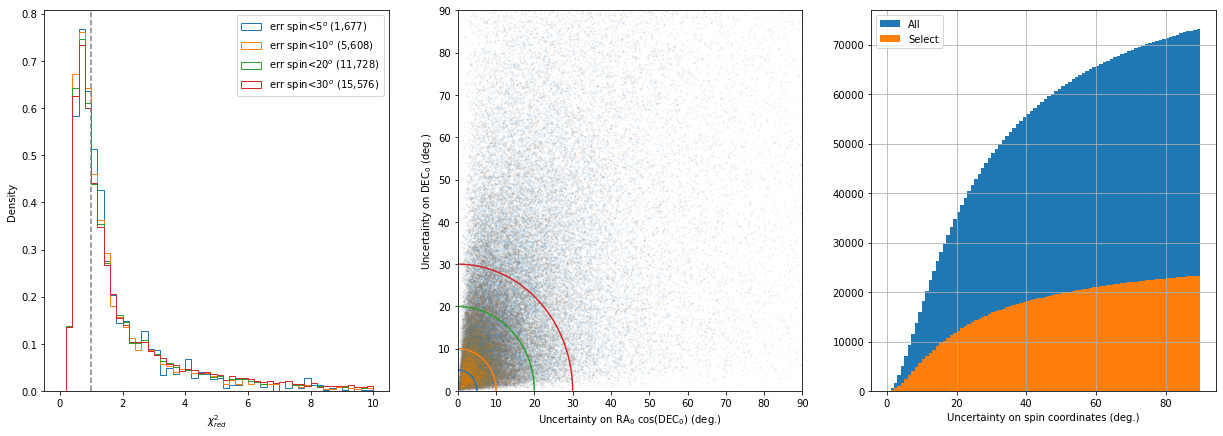

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))


# Histogram of chi2
for err in [5,10,20,30]:
    cond = maskFINK
    cond = cond*(data.HG1G2hyb_dSpin<=err)
    ax[0].hist(data.loc[cond,'HG1G2hyb_chi2red'], bins=50, histtype='step', density=True, range=[0,10],
               label=f'err spin<{err:d}$^o$ ({len(data[cond]):,d})')

    theta = np.linspace(0, np.pi/2, num=90 )
    ax[1].plot( err*np.cos(theta), err*np.sin(theta) )
    
ax[0].axvline(1, ls='--', color='grey')
ax[0].set_xlabel(r'$\chi^2_{red}$')
ax[0].set_ylabel('Density')
ax[0].legend()


# Scatter dRA dDEC
ax[1].scatter( data.HG1G2hyb_dRA0*np.cos(np.radians(data['HG1G2hyb_DEC0'])), data.HG1G2hyb_dDEC0, s=1, alpha=0.05 )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_dRA0']*np.cos(np.radians(data.loc[maskFINK,'HG1G2hyb_DEC0'])), data.loc[maskFINK,'HG1G2hyb_dDEC0'], s=1, alpha=0.05 )
ax[1].set_xlim(0,90)
ax[1].set_ylim(0,90)

ax[1].set_xlabel('Uncertainty on RA$_0$ cos(DEC$_0$) (deg.)')
ax[1].set_ylabel('Uncertainty on DEC$_0$ (deg.)')

# Cumulative dSpin
r = [0,90]
b = 90
ax[2].hist( data.HG1G2hyb_dSpin, cumulative=True, density=False, range=r, bins=b, label='All' )
ax[2].hist( data.loc[maskFINK,'HG1G2hyb_dSpin'], cumulative=True, density=False, range=r, bins=b, label='Select' )

ax[2].grid()
ax[2].set_xlabel('Uncertainty on spin coordinates (deg.)')
ax[2].legend(loc='upper left')

# fig.savefig(f'{data_fink}plots/uncertainties_spin.png', facecolor='white', dpi=150)


Text(0, 0.5, 'DEC0 (deg)')

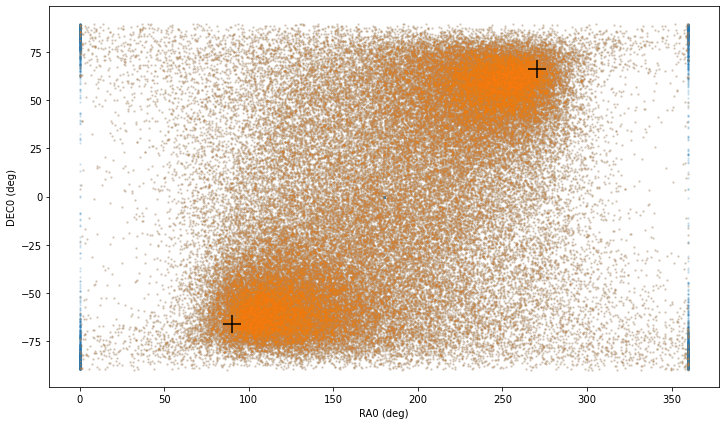

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

cond = data.ssnamenr==data.ssnamenr
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15)

cond = maskSpin
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15)

coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
# fig.savefig(f'{data_fink}plots/ra0_vs_dec0_with_flip.png', facecolor='white', dpi=150)



- There are a few weird solution at RA0=0 or RA0=360 
- We need to flip RA/DEC of half the solution

Text(0.5, 0, 'DEC_0')

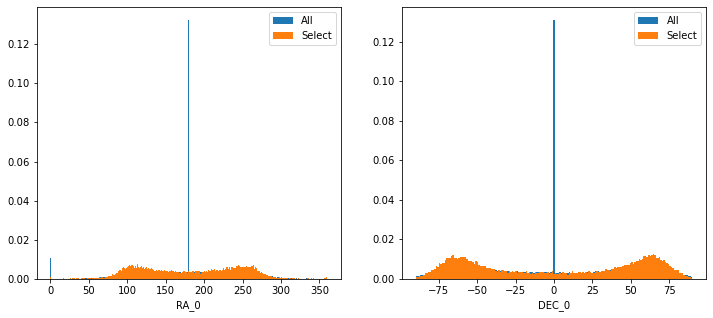

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].hist( data.HG1G2hyb_RA0, range=[0,360], bins=361, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'HG1G2hyb_RA0'], range=[0,360], bins=361, density=True, label='Select' )
ax[0].legend()
ax[0].set_xlabel('RA_0')

ax[1].hist( data.HG1G2hyb_DEC0, range=[-90,90], bins=181, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'HG1G2hyb_DEC0'], range=[-90,90], bins=181, density=True, label='Select' )
ax[1].legend()
ax[1].set_xlabel('DEC_0')

In [15]:
# Flip half of the solution
cond = (data.index %2 ==0 )
xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

data.loc[cond,xax] = (data.loc[cond,xax]+180) % 360
data.loc[cond,yax] = -data.loc[cond,yax]

# Convert (again) to EC
coords = SkyCoord(ra=data.loc[cond,xax]*u.deg, dec=data.loc[cond,yax]*u.deg, distance=200*u.parsec, frame='hcrs')
data.loc[cond,'lon'] = coords.heliocentricmeanecliptic.lon.value
data.loc[cond,'lat'] = coords.heliocentricmeanecliptic.lat.value

Text(0, 0.5, 'DEC0 (deg)')

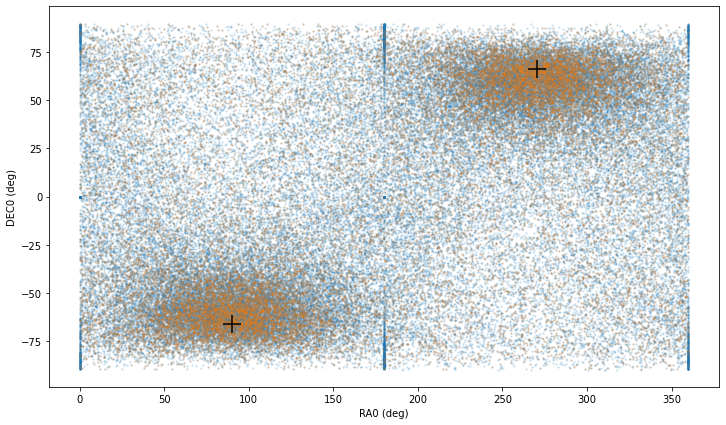

In [16]:
fig, ax = plt.subplots(figsize=(12, 7))

cond = data.ssnamenr==data.ssnamenr
xax = 'HG1G2hyb_RA0'
yax = 'HG1G2hyb_DEC0'

ax.scatter( data.loc[cond,xax], 
            data.loc[cond,yax], 
            s=2, alpha=0.15)

ax.scatter( data.loc[maskFINK,xax], 
            data.loc[maskFINK,yax], 
            s=2, alpha=0.15)

coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
# fig.savefig(f'{data_fink}plots/ra0_vs_dec0_with_flip.png', facecolor='white', dpi=150)



# Compare with literature

In [17]:
data['spins.1.technique'].value_counts()

LC        15872
LCI        2654
LC+TPM      568
TE           90
ADAM         42
LC-TPM       40
LC+Occ       16
Radar        16
SPACE         5
A-M           5
LC+IM         4
SAGE          4
Bin-IM        1
TE-Occ        1
Name: spins.1.technique, dtype: int64

In [18]:
# Compute angular distances
spin_version = np.array(['A','B'])

for ks in ['1','2','3','4']:
    data[f'spins.{ks}.distance'] = np.nan
    cond = (~data[f'spins.{ks}.RA0.value'].isna())
    
    #------------------------------------------------------------------------------------------
    # A: Original spins
    data.loc[cond,f'spins.{ks}.distance.A'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'HG1G2hyb_RA0','HG1G2hyb_DEC0']].apply(
        lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.A'] = (data.loc[cond,f'spins.{ks}.RA0.value']-data.loc[cond,'HG1G2hyb_RA0'] ) * np.cos(np.radians(data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.A'] = (data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'HG1G2hyb_DEC0'] )

    #------------------------------------------------------------------------------------------
    # B: RA-180 & Flip DEC
    data.loc[cond,f'spins.{ks}.distance.B'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'HG1G2hyb_RA0','HG1G2hyb_DEC0']].apply(
        lambda x: np.degrees(angular_separation( np.radians( (x[0]+180) % 360 ), np.radians(-x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.B'] = ( ((data.loc[cond,f'spins.{ks}.RA0.value']+180.0) % 360 )-data.loc[cond,'HG1G2hyb_RA0'] ) * np.cos(np.radians(-data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.B'] = (-data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'HG1G2hyb_DEC0'] )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.closest'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: int(np.argmin(x)), axis=1 )
    data = data.astype({f'spins.{ks}.closest':'Int64'})

    data.loc[cond,f'spins.{ks}.distance'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                            f'spins.{ks}.distance.B']].apply( lambda x: np.min(x), axis=1 )
    data.loc[cond,f'spins.{ks}.version'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: spin_version[np.argmin(x)], axis=1 )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.delta_RA'] = data.loc[cond, [f'spins.{ks}.delta_RA.A',
                                                            f'spins.{ks}.delta_RA.B', 
                                                            f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )
    data.loc[cond,f'spins.{ks}.delta_DEC'] = data.loc[cond, [f'spins.{ks}.delta_DEC.A',
                                                             f'spins.{ks}.delta_DEC.B', 
                                                             f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )

    
# Select the closest angularly
cond = ~data[f'spins.1.distance'].isna()
data.loc[cond,'spins.closest'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: int(np.argmin(x)), axis=1 )
data = data.astype({'spins.closest':'Int64'})

data.loc[cond,'spins.distance'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: np.min(x), axis=1 )
data.loc[cond,'spins.delta_RA'] = data.loc[cond, [f'spins.1.delta_RA',
                                                  f'spins.2.delta_RA',
                                                  f'spins.3.delta_RA',
                                                  f'spins.4.delta_RA', 
                                                  f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )
data.loc[cond,'spins.delta_DEC'] = data.loc[cond, [f'spins.1.delta_DEC',
                                                   f'spins.2.delta_DEC',
                                                   f'spins.3.delta_DEC',
                                                   f'spins.4.delta_DEC', 
                                                   f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )



(0.0, 90.0)

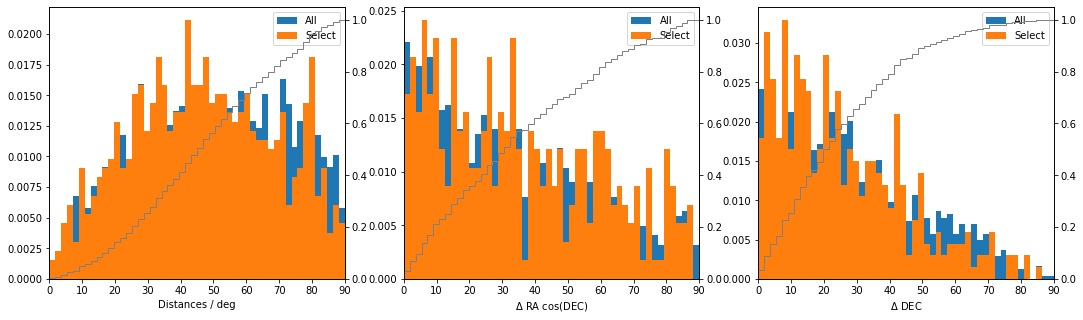

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

r = [0,90]
b = 50
ax[0].hist( data.loc[cond,'spins.distance'], range=r, bins=b, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, label='Select' )
ax[0].legend()
ax[0].set_xlabel('Distances / deg')
ax0 = ax[0].twinx()
ax0.hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax[0].set_xlim(r)

ax[1].hist( data.loc[cond,'spins.delta_RA'], range=r, bins=b, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, label='Select' )
ax[1].legend()
ax[1].set_xlabel('$\Delta$ RA cos(DEC)')
ax1 = ax[1].twinx()
ax1.hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax[1].set_xlim(r)

ax[2].hist( data.loc[cond,'spins.delta_DEC'], range=r, bins=b, density=True, label='All' )
ax[2].hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, label='Select' )
ax[2].legend()
ax[2].set_xlabel('$\Delta$ DEC')
ax2 = ax[2].twinx()
ax2.hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax[2].set_xlim(r)


Text(0, 0.5, 'Distances / deg')

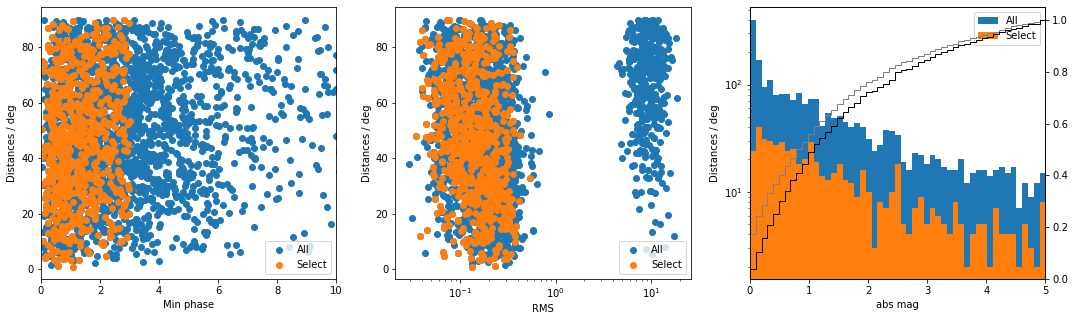

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

ax[0].scatter( data.loc[cond,'minphase'], data.loc[cond,'spins.distance'], label='All' )
ax[0].scatter( data.loc[maskFINK,'minphase'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[0].legend()
ax[0].set_xlabel('Min phase')
ax[0].set_ylabel('Distances / deg')
ax[0].set_xlim(0,10)


ax[1].scatter( data.loc[cond,'HG1G2hyb_rms'], data.loc[cond,'spins.distance'], label='All' )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_rms'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[1].legend()
ax[1].set_xlabel('RMS')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

r = [0,5]
b = 51
ax[2].hist( data.loc[cond,'spins.distance']/data.loc[cond,'HG1G2hyb_dSpin'], range=r, bins=b, label='All' )
ax[2].hist( data.loc[maskFINK,'spins.distance']/data.loc[maskFINK,'HG1G2hyb_dSpin'], range=r, bins=b, label='Select' )
ax2 = ax[2].twinx()
ax2.hist( data.loc[cond,'spins.distance']/data.loc[cond,'HG1G2hyb_dSpin'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='gray' )
ax2.hist( data.loc[maskFINK,'spins.distance']/data.loc[maskFINK,'HG1G2hyb_dSpin'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[2].set_xlim(r)

ax[2].legend()
ax[2].set_xlabel('abs mag')
ax[2].set_yscale('log')
ax[2].set_ylabel('Distances / deg')


In [35]:
data.columns[:80]

Index(['ssnamenr', 'number', 'name', 'minphase', 'maxphase', 'n_days', 'n_obs',
       'HG_H', 'HG_dH', 'HG_G', 'HG_dG', 'HG_rms', 'HG_chi2red', 'HG1G2_H',
       'HG1G2_dH', 'HG1G2_G1', 'HG1G2_dG1', 'HG1G2_G2', 'HG1G2_dG2',
       'HG1G2_rms', 'HG1G2_chi2red', 'HG1G2sp_H', 'HG1G2sp_dH', 'HG1G2sp_G1',
       'HG1G2sp_dG1', 'HG1G2sp_G2', 'HG1G2sp_dG2', 'HG1G2sp_RA0',
       'HG1G2sp_dRA0', 'HG1G2sp_DEC0', 'HG1G2sp_dDEC0', 'HG1G2sp_R',
       'HG1G2sp_dR', 'HG1G2sp_rms', 'HG1G2sp_chi2red', 'HG1G2hyb_H_g',
       'HG1G2hyb_dH_g', 'HG1G2hyb_G1_g', 'HG1G2hyb_dG1_g', 'HG1G2hyb_G2_g',
       'HG1G2hyb_dG2_g', 'HG1G2hyb_H_r', 'HG1G2hyb_dH_r', 'HG1G2hyb_G1_r',
       'HG1G2hyb_dG1_r', 'HG1G2hyb_G2_r', 'HG1G2hyb_dG2_r', 'HG1G2hyb_RA0',
       'HG1G2hyb_dRA0', 'HG1G2hyb_DEC0', 'HG1G2hyb_dDEC0', 'HG1G2hyb_R',
       'HG1G2hyb_dR', 'HG1G2hyb_rms', 'HG1G2hyb_chi2red', 'HG1G2hyb_n_oppo',
       'HG1G2hyb_status', 'HG1G2hyb_fit', 'HG1G2hyb_dSpin', 'lon', 'lat',
       'sso_number', 'sso_name', 'sso_cl

Text(0, 0.5, 'Distances / deg')

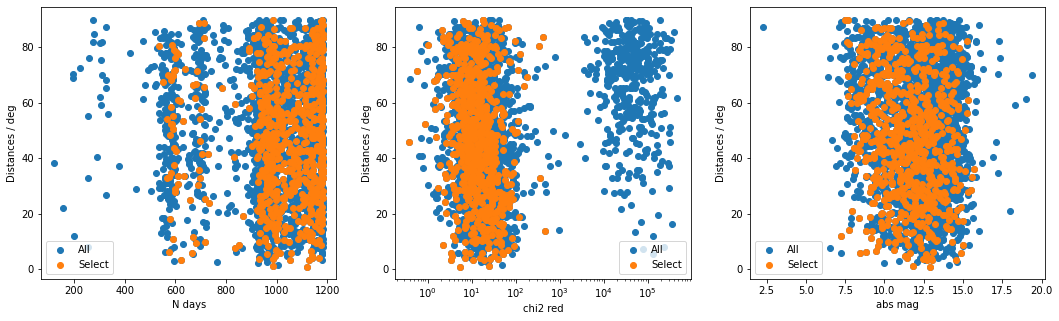

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

ax[0].scatter( data.loc[cond,'n_days'], data.loc[cond,'spins.distance'], label='All' )
ax[0].scatter( data.loc[maskFINK,'n_days'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[0].legend()
ax[0].set_xlabel('N days')
ax[0].set_ylabel('Distances / deg')

ax[1].scatter( data.loc[cond,'HG1G2hyb_chi2red'], data.loc[cond,'spins.distance'], label='All' )
ax[1].scatter( data.loc[maskFINK,'HG1G2hyb_chi2red'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[1].legend()
ax[1].set_xlabel('chi2 red')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

ax[2].scatter( data.loc[cond,'absolute_magnitude.value'], data.loc[cond,'spins.distance'], label='All' )
ax[2].scatter( data.loc[maskFINK,'absolute_magnitude.value'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[2].legend()
ax[2].set_xlabel('abs mag')
# ax[2].set_xscale('log')
ax[2].set_ylabel('Distances / deg')


(29423, 2799)

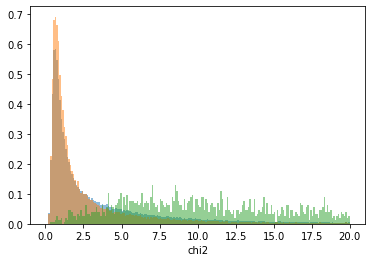

In [22]:
r = [0,20]
b = 200 
plt.hist(data['HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'HG1G2hyb_chi2red'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

- fishy: the object with spins have shitty chi2red!
- Explanation: there is bias for high amplitude for LC-derived spins -> bad for HG1G2hybrid (LC not taken into account)

(29423, 2799)

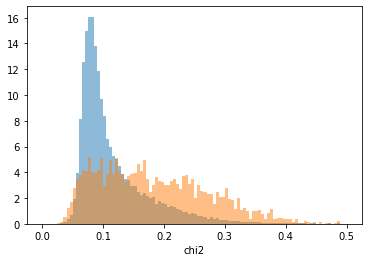

In [23]:
r = [0,0.5]
b = 100 
# plt.hist(data['HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'HG1G2hyb_rms'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

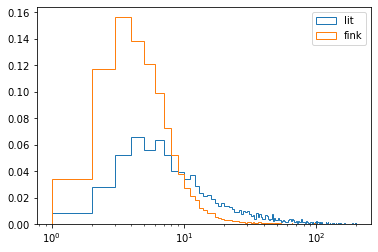

In [24]:
fig, ax = plt.subplots()

ax.hist( data.loc[cond,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='lit')
ax.hist( data.loc[maskFINK,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='fink' )

ax.set_xscale('log')
ax.legend()

In [25]:
cond = maskFINK
lim_spin = 30
spin_v = '1'
cond = cond * (data[f'spins.{spin_v}.distance'] < lim_spin)
data.loc[cond,f'spins.{spin_v}.technique'].value_counts()

# plt.hist( data.loc[cond,'spins.1.distance'] )

LCI       100
LC+TPM     28
LC          6
LC-TPM      3
LC+Occ      2
TE          1
ADAM        1
Name: spins.1.technique, dtype: int64

In [26]:
cond = maskFINK
cond = cond * (data[f'spins.{spin_v}.distance'] < lim_spin)
cond = cond * (data[f'spins.{spin_v}.technique']=='LC+TPM')

cols = ['number','name', #'minphase','maxphase','n_days',
        'HG1G2hyb_RA0','HG1G2hyb_DEC0',
        'spins.1.RA0.value','spins.1.DEC0.value', 'spins.1.version',
        'spins.2.RA0.value','spins.2.DEC0.value', 'spins.2.version',
        'spins.1.distance', 'spins.2.distance']
data.loc[cond,cols].sort_values(by='number')
# data.loc[cond,'spins.1.technique'].value_counts()

,number,name,HG1G2hyb_RA0,HG1G2hyb_DEC0,spins.1.RA0.value,spins.1.DEC0.value,spins.1.version,spins.2.RA0.value,spins.2.DEC0.value,spins.2.version,spins.1.distance,spins.2.distance
53547,125,Liberatrix,249.316275,68.256765,274.766482,59.892991,A,NaN,NaN,NaN,13.752406,NaN
101175,159,Aemilia,131.125002,-84.520435,215.905000,72.905000,B,315.584,47.709,B,18.396180,36.830029
54085,195,Eurykleia,138.193182,-42.668841,276.349000,56.040000,B,NaN,NaN,NaN,29.757005,NaN
103330,272,Antonia,290.309228,52.678104,86.229039,-65.281950,B,NaN,NaN,NaN,17.476665,NaN
90286,299,Thora,269.246749,72.756691,83.644000,-62.453000,B,NaN,NaN,NaN,10.511412,NaN
53335,321,Florentina,118.439524,-59.843597,113.560163,-87.310544,A,NaN,NaN,NaN,27.477556,NaN
21009,355,Gabriella,257.894774,57.787738,267.485533,66.592947,A,NaN,NaN,NaN,9.851455,NaN
98654,384,Burdigala,278.131186,63.557069,84.073000,-61.808000,B,NaN,NaN,NaN,6.669182,NaN
44452,427,Galene,282.930616,66.164398,168.407000,-86.818000,B,76.744,-33.477,B,22.689457,36.192968
89295,583,Klotilde,194.823578,80.192889,178.794000,50.937000,A,302.626,40.197,A,29.741506,53.401170


In [27]:
cond = maskFINK
data[cond].sort_values(by='sso_number').head(20)

,ssnamenr,number,name,minphase,maxphase,n_days,n_obs,HG_H,HG_dH,HG_G,...,spins.4.delta_RA.B,spins.4.delta_DEC.B,spins.4.closest,spins.4.version,spins.4.delta_RA,spins.4.delta_DEC,spins.closest,spins.distance,spins.delta_RA,spins.delta_DEC
75873,21,21,Lutetia,2.817588,26.388033,984.038032,89,7.528395,0.106462,2.270216e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,89.737302,-125.833830,62.435802
99158,24,24,Themis,1.037637,19.738912,1125.539445,82,6.978320,0.070092,9.613605e-17,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,12.181428,-12.513243,-4.511321
75079,38,38,Leda,0.675514,22.034192,1163.636458,97,8.613089,0.055079,2.502589e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,1,68.596550,59.444718,57.302265
8121,46,46,Hestia,0.681605,29.102391,1178.660880,131,8.544425,0.129448,1.317698e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,1,80.476965,-48.694701,70.921332
65784,53,53,Kalypso,0.948405,28.342319,998.970671,126,8.805468,0.059812,9.401087e-18,...,NaN,NaN,<NA>,NaN,NaN,NaN,1,77.330040,74.391256,44.401595
84579,58,58,Concordia,1.171909,22.695131,1138.565023,137,8.800727,0.046967,7.480369e-03,...,NaN,NaN,<NA>,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
62548,62,62,Erato,1.134555,21.992419,935.015567,192,9.024820,0.088418,3.168398e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,63.307694,46.539120,49.031372
88684,73,73,Klytia,1.444382,23.224216,953.039062,173,9.329561,0.068905,3.600937e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,40.073331,32.548955,-14.060526
9074,76,76,Freia,0.112639,20.263291,963.949155,152,8.034067,0.050235,2.232379e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,1,74.132674,-16.473402,-73.489561
37111,77,77,Frigga,0.764958,24.719039,974.061643,134,8.596117,0.032609,7.610106e-02,...,NaN,NaN,<NA>,NaN,NaN,NaN,0,48.530521,55.176204,1.577431


In [30]:
cond = maskFINK
cols = ['number','name', #'minphase','maxphase','n_days',
        'HG1G2hyb_RA0','HG1G2hyb_DEC0',
        'spins.1.RA0.value','spins.1.DEC0.value', 'spins.1.version',
        'spins.2.RA0.value','spins.2.DEC0.value', 'spins.2.version',
        'spins.1.distance', 'spins.2.distance']
data.loc[cond,cols].sort_values(by='number').head(20)

,number,name,HG1G2hyb_RA0,HG1G2hyb_DEC0,spins.1.RA0.value,spins.1.DEC0.value,spins.1.version,spins.2.RA0.value,spins.2.DEC0.value,spins.2.version,spins.1.distance,spins.2.distance
75873,21,Lutetia,359.902885,-73.235802,51.800,10.800,B,NaN,NaN,NaN,89.737302,NaN
99158,24,Themis,275.214852,69.024321,246.135,64.513,A,NaN,NaN,NaN,12.181428,NaN
75079,38,Leda,285.857542,-69.516265,155.139,-7.940,B,346.679,-12.214,A,84.451302,68.596550
8121,46,Hestia,159.993944,-61.978332,112.808,28.869,B,290.700,-8.943,B,81.570135,80.476965
65784,53,Kalypso,92.265902,-47.412595,173.803,15.763,B,346.760,3.011,B,84.021135,77.330040
84579,58,Concordia,110.820209,56.730991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62548,62,Erato,42.538532,-48.595372,269.079,-0.436,B,86.037,45.398,B,63.307694,78.628543
88684,73,Klytia,21.788732,-49.203474,274.139,63.264,B,NaN,NaN,NaN,40.073331,NaN
9074,76,Freia,333.378578,74.779561,145.914,28.010,A,316.901,1.290,A,77.095005,74.132674
37111,77,Frigga,114.969870,-58.968431,217.356,-57.391,A,39.399,56.788,B,48.530521,49.717947


In [44]:
data.columns[:80]

Index(['ssnamenr', 'number', 'name', 'minphase', 'maxphase', 'n_days', 'n_obs',
       'HG_H', 'HG_dH', 'HG_G', 'HG_dG', 'HG_rms', 'HG_chi2red', 'HG1G2_H',
       'HG1G2_dH', 'HG1G2_G1', 'HG1G2_dG1', 'HG1G2_G2', 'HG1G2_dG2',
       'HG1G2_rms', 'HG1G2_chi2red', 'HG1G2sp_H', 'HG1G2sp_dH', 'HG1G2sp_G1',
       'HG1G2sp_dG1', 'HG1G2sp_G2', 'HG1G2sp_dG2', 'HG1G2sp_RA0',
       'HG1G2sp_dRA0', 'HG1G2sp_DEC0', 'HG1G2sp_dDEC0', 'HG1G2sp_R',
       'HG1G2sp_dR', 'HG1G2sp_rms', 'HG1G2sp_chi2red', 'HG1G2hyb_H_g',
       'HG1G2hyb_dH_g', 'HG1G2hyb_G1_g', 'HG1G2hyb_dG1_g', 'HG1G2hyb_G2_g',
       'HG1G2hyb_dG2_g', 'HG1G2hyb_H_r', 'HG1G2hyb_dH_r', 'HG1G2hyb_G1_r',
       'HG1G2hyb_dG1_r', 'HG1G2hyb_G2_r', 'HG1G2hyb_dG2_r', 'HG1G2hyb_RA0',
       'HG1G2hyb_dRA0', 'HG1G2hyb_DEC0', 'HG1G2hyb_dDEC0', 'HG1G2hyb_R',
       'HG1G2hyb_dR', 'HG1G2hyb_rms', 'HG1G2hyb_chi2red', 'HG1G2hyb_n_oppo',
       'HG1G2hyb_status', 'HG1G2hyb_fit', 'HG1G2hyb_dSpin', 'lon', 'lat',
       'sso_number', 'sso_name', 'sso_cl

# Obliquity

In [45]:
# Obliquity of the spin
data['lon_orbit'] = data['orbital_elements.node_longitude.value'] - 90
data['lat_orbit'] = 90. - data['orbital_elements.inclination.value']
data['obliquity'] = data[['lon','lat', 'lon_orbit','lat_orbit']].apply(
    lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
)


Text(0, 0.5, 'Obliquity / deg')

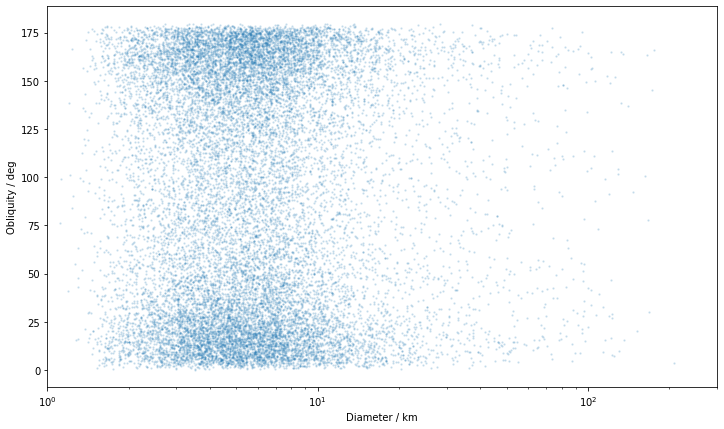

In [52]:
fig, ax = plt.subplots(figsize=(12, 7))

cond = data.ssnamenr==data.ssnamenr
cond = maskFINK
ax.scatter( data.loc[cond,'diameter.value'],
            data.loc[cond,'obliquity'], 
            s=2, alpha=0.15 )

ax.set_xscale('log')
ax.set_xlim(1,300)
ax.set_xlabel('Diameter / km')
ax.set_ylabel('Obliquity / deg')

# fig.savefig(f'{data_fink}plots/obliquity_vs_diameter.png', facecolor='white', dpi=150)


# Oblateness

In [53]:
damit = pd.read_csv( f'{data_fink}/data/damit.csv' )

In [85]:
np.mean(damit.R)

0.6131972585404981

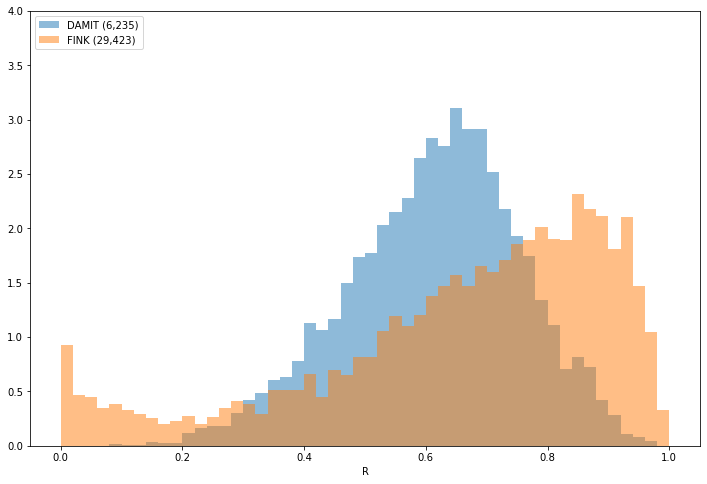

In [90]:
fig, ax = plt.subplots(figsize=(12,8))

r = [0,1]
b = 50

ax.hist( damit.R, range=r, bins=b, density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )
# ax.hist( data.loc[maskFINK,'HG1G2hyb_R'], range=r, bins=b, density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

cond = (data.HG1G2hyb_dR<0.1) & maskFINK
ax.hist( data.loc[cond,'HG1G2hyb_R'], range=r, bins=b, density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

ax.set_ylim(0,4)
ax.set_xlabel('R')
ax.legend(loc='upper left')

In [93]:
# damit.sort_values(by='R').head(40)
cond = maskFINK & (data.HG1G2hyb_R>0.18)
data[cond].sort_values(by='HG1G2hyb_R').head(40)

,ssnamenr,number,name,minphase,maxphase,n_days,n_obs,HG_H,HG_dH,HG_G,...,spins.4.delta_RA,spins.4.delta_DEC,spins.closest,spins.distance,spins.delta_RA,spins.delta_DEC,lon_orbit,lat_orbit,obliquity,obliquity_alt
89217,7412,7412,Linnaeus,0.289574,19.475603,949.949873,169,13.093161,0.036314,9.006944e-02,...,NaN,NaN,<NA>,NaN,NaN,NaN,9.174558,87.426405,3.761506,176.238494
14112,178696,178696,2000 SB58,0.825724,19.903504,602.784965,55,14.968555,0.038764,9.711355e-02,...,NaN,NaN,<NA>,NaN,NaN,NaN,80.363584,80.221896,42.518051,137.481949
68506,27337,27337,2000 CR90,1.206443,25.000178,507.961458,56,15.741553,0.058816,3.298380e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,92.037740,78.850804,137.413065,42.586935
53315,71816,71816,2000 UY7,1.723168,26.124891,1156.582928,64,15.651084,0.084308,1.685586e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,112.557123,84.293277,9.125260,170.874740
100291,36666,36666,2000 QA212,0.069681,21.151219,948.057928,56,15.404400,0.043843,1.037851e-13,...,NaN,NaN,<NA>,NaN,NaN,NaN,254.531115,87.264048,139.823422,40.176578
64064,25233,25233,Tallman,1.802103,20.824451,996.854271,143,13.762201,0.049723,5.778620e-02,...,NaN,NaN,<NA>,NaN,NaN,NaN,105.381622,79.942609,150.376013,29.623987
57245,54825,54825,2001 NE7,2.942434,19.100556,947.957083,72,14.310625,0.075192,8.162011e-03,...,NaN,NaN,<NA>,NaN,NaN,NaN,227.145911,81.173760,149.365445,30.634555
25711,30614,30614,2778 P-L,1.219789,24.364929,973.992164,120,14.985186,0.064622,1.539948e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,77.435088,88.375945,7.152366,172.847634
11594,41841,41841,2000 WF60,2.840209,27.118177,700.701400,66,14.972658,0.048778,2.386247e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,104.830408,86.427903,167.051355,12.948645
18235,68400,68400,2001 QM91,1.730574,21.877634,1057.668275,127,14.500415,0.080064,1.337904e-01,...,NaN,NaN,<NA>,NaN,NaN,NaN,117.605213,80.383614,166.908322,13.091678


Text(0, 0.5, 'R')

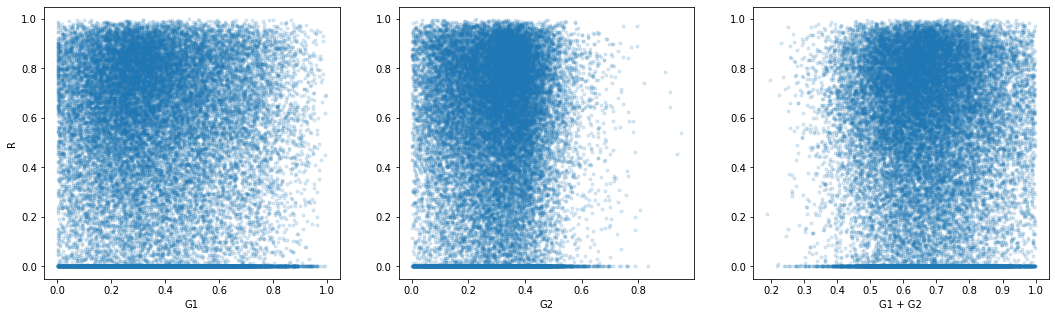

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

r = [0,1]
b = 50


cond = maskFINK

ax[0].scatter( data.loc[cond,'HG1G2hyb_G1_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )
ax[1].scatter( data.loc[cond,'HG1G2hyb_G2_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )
ax[2].scatter( data.loc[cond,'HG1G2hyb_G1_r']+data.loc[cond,'HG1G2hyb_G2_r'], data.loc[cond,'HG1G2hyb_R'], marker='.', alpha=0.15 )

ax[0].set_xlabel('G1')
ax[1].set_xlabel('G2')
ax[2].set_xlabel('G1 + G2')
ax[0].set_ylabel('R')

# ax.legend(loc='upper left')

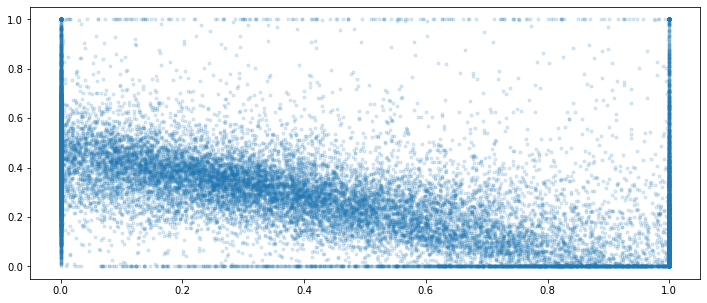

In [84]:
fig, ax = plt.subplots(figsize=(12,5))

r = [0,1]
b = 50

cond = data['HG1G2hyb_R']<0.2

ax.scatter( data.loc[cond,'HG1G2hyb_G1_r'], data.loc[cond,'HG1G2hyb_G2_r'], marker='.', alpha=0.15 )

# ax[0].set_xlabel('G1')
# ax[1].set_xlabel('G2')
# ax[2].set_xlabel('G1 + G2')
# ax[0].set_ylabel('R')

# ax.legend(loc='upper left')